# Food Vision Project

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3692af30-f199-3447-6188-b17cacfda1c2)


In [2]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-22 07:53:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-22 07:53:00 (72.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Import helper functions

In [3]:
from helper_functions import *

### Get datasets from Tensorflow

In [4]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [5]:
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()

In [7]:
(train_data, test_data), ds_info = tfds.load(
    name = 'food101',
    split = ['train', 'validation'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True # metadata
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteGZ1JS8/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteGZ1JS8/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names

In [10]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_data

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
train_one_sample = train_data.take(1)

In [13]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 31
  Class name (str form): donuts
        


In [15]:
tf.reduce_min(image), tf.reduce_max(image) # find min and max of image values

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

In [16]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[131,  86,  55],
        [134,  89,  58],
        [137,  92,  61],
        ...,
        [131,  44,   0],
        [135,  49,   2],
        [138,  52,   5]],

       [[134,  89,  58],
        [135,  90,  59],
        [135,  90,  59],
        ...,
        [133,  46,   1],
        [134,  48,   1],
        [134,  48,   1]],

       [[136,  91,  60],
        [137,  92,  61],
        [139,  94,  63],
        ...,
        [137,  53,   7],
        [135,  51,   5],
        [131,  47,   1]],

       ...,

       [[130,  23,   3],
        [134,  31,  14],
        [132,  36,  24],
        ...,
        [243, 248, 242],
        [243, 248, 242],
        [243, 248, 242]],

       [[128,  22,   0],
        [129,  26,   7],
        [124,  28,  14],
        ...,
        [243, 248, 241],
        [242, 247, 240],
        [242, 247, 240]],

       [[132,  26,   2],
        [133,  31,   9],
        [126,  29,  13],
        ...,
        [242, 247, 24

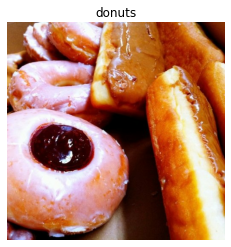

In [17]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [18]:
def preprocess_img(image, label, shape = 224):
  """Converts image datatype"""
  image = tf.image.resize(image, [shape, shape])

  return tf.cast(image, tf.float32), label

In [19]:
processed_img = preprocess_img(image, label)[0]

In [20]:
processed_img.shape, processed_img.dtype

(TensorShape([224, 224, 3]), tf.float32)

Map processign. function to train data and parallelelize

In [21]:
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

In [22]:
test_data = test_data.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

### Create Modelling Callbacks

* TensorBoard
* Early Stopping
* Model Checkpoint

In [23]:
checkpoint_path = 'checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'val_acc',
    save_weights_only = True,
    save_best_only = True,
    verbose = 0
)

### Setup Mixed Precision Training

In [24]:
from tensorflow.keras import mixed_precision

In [25]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [28]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = 'input_layer')

16719872/16705208 [==============================] - 0s 0us/step


In [29]:
x = base_model(inputs, training = False) # keep in inference mode
x = layers.GlobalAveragePooling2D()(x)
X = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)

In [30]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 softmax_float32 (Activation  (None, 1280)             0         
 )                                                               
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [32]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit Feature Extraction Model

In [ ]:
history = model.fit(
    train_data,
    epochs = 3,
    validation_data = test_data,
    validation_steps = 0.15*len(test_data),
    callbacks = [create_tensorboard_callback(dir_name = 'training_logs', experiment_name = 'food classed feature extract'),
                 model_checkpoint]
)

Saving TensorBoard log files to: training_logs/food classed feature extract/20220622-080055
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 7.2438 - accuracy: 4.3564e-04WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 186s 71ms/step - loss: 7.2438 - accuracy: 4.3564e-04 - val_loss: 7.2340 - val_accuracy: 2.6261e-04
Epoch 2/3
1945/2368 [=======================>......] - ETA: 27s - loss: 7.2449 - accuracy: 4.6594e-04

In [ ]:
results_feature_extract = model.evaluate(test_data)